In [14]:
!pip install pydicom
!pip install dicom

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 766.3/766.3 kB 15.9 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [15]:
# Libraries
import os
import re
import gc
import cv2
from PIL import Image
import random
import math
import shutil
from tqdm import tqdm
from pprint import pprint
from time import time
import warnings
import itertools
import seaborn as sns
import matplotlib as mpl
from matplotlib import cm
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.patches import Rectangle
from IPython.display import display_html
plt.rcParams.update({'font.size': 16})
import scipy.ndimage
import numpy as np
from glob import glob
# import pydicom
import pylab as pl
import sys
import matplotlib.path as mplPath
import plotly
import seaborn as sns
import scipy.ndimage
from skimage import measure
import plotly.graph_objects as go
from plotly.figure_factory import create_trisurf
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from itertools import chain
# .dcm handling
import pydicom
import nibabel as nib
from pydicom.pixel_data_handlers.util import apply_voi_lut

# Environment check
warnings.filterwarnings("ignore")
os.environ["WANDB_SILENT"] = "true"
CONFIG = {'competition': 'RSNA_SpineFructure', '_wandb_kernel': 'aot'}

# Custom colors
class clr:
    S = '\033[1m' + '\033[94m'
    E = '\033[0m'

my_colors = ["#5EAFD9", "#449DD1", "#3977BB",
             "#2D51A5", "#5C4C8F", "#8B4679",
             "#C53D4C", "#E23836", "#FF4633", "#FF5746"]
CMAP1 = ListedColormap(my_colors)

In [ ]:
data = np.load('/content/gdrive/MyDrive/KOLN3D/DL_BoneImageSeg/npyfiles/1.2.826.0.1.3680043.14_1_0.npy')
# data = np.transpose(data, (2, 0, 1))
data.shape

(224, 224, 6)

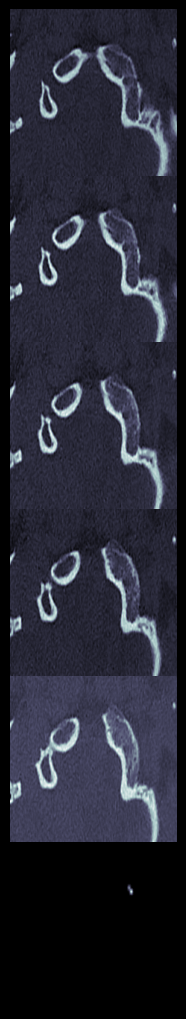

In [ ]:
plot(data, 6, 6, 1)

5 Pictures -> 1 Mask

In [4]:
data_list = []
folder_path = "/content/gdrive/MyDrive/KOLN3D/DL_BoneImageSeg/npyfiles" # Replace with the path to your folder

# Get a list of all the filenames in the folder, sorted by the number at the end
filenames = sorted(os.listdir(folder_path), key=lambda x: int(x.split("_")[-1].split(".")[0]))

# Loop through the sorted filenames and load the data
for filename in filenames:
    if filename.endswith(".npy"):
        data = np.load(os.path.join(folder_path, filename))
        data_list.append(data)

image_list = [arr[:, :, :1] for arr in data_list]
data_list = [arr[:, :, 5:] for arr in data_list]

In [280]:
print(len(data_list))
print(data_list[0].shape)
print(len(image_list))
print(image_list[0].shape)

15
(224, 224, 1)
15
(224, 224, 1)


In [281]:
def plot(img_list):
    num_images = len(img_list)
    columns = int(math.sqrt(num_images))
    rows = int(math.ceil(num_images / columns))

    # Define figure size
    figsize = (16, 10)

    # Create the subplot grid
    fig, axes = plt.subplots(rows, columns, figsize=figsize)

    # Plot the images in a tight grid
    for i, ax in enumerate(axes.flatten()):
        if i < num_images:
            img = img_list[i][:, :, 0]
            ax.imshow(img, cmap=plt.cm.bone)
            ax.axis('off')
        else:
            ax.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)  # no space
    plt.show()

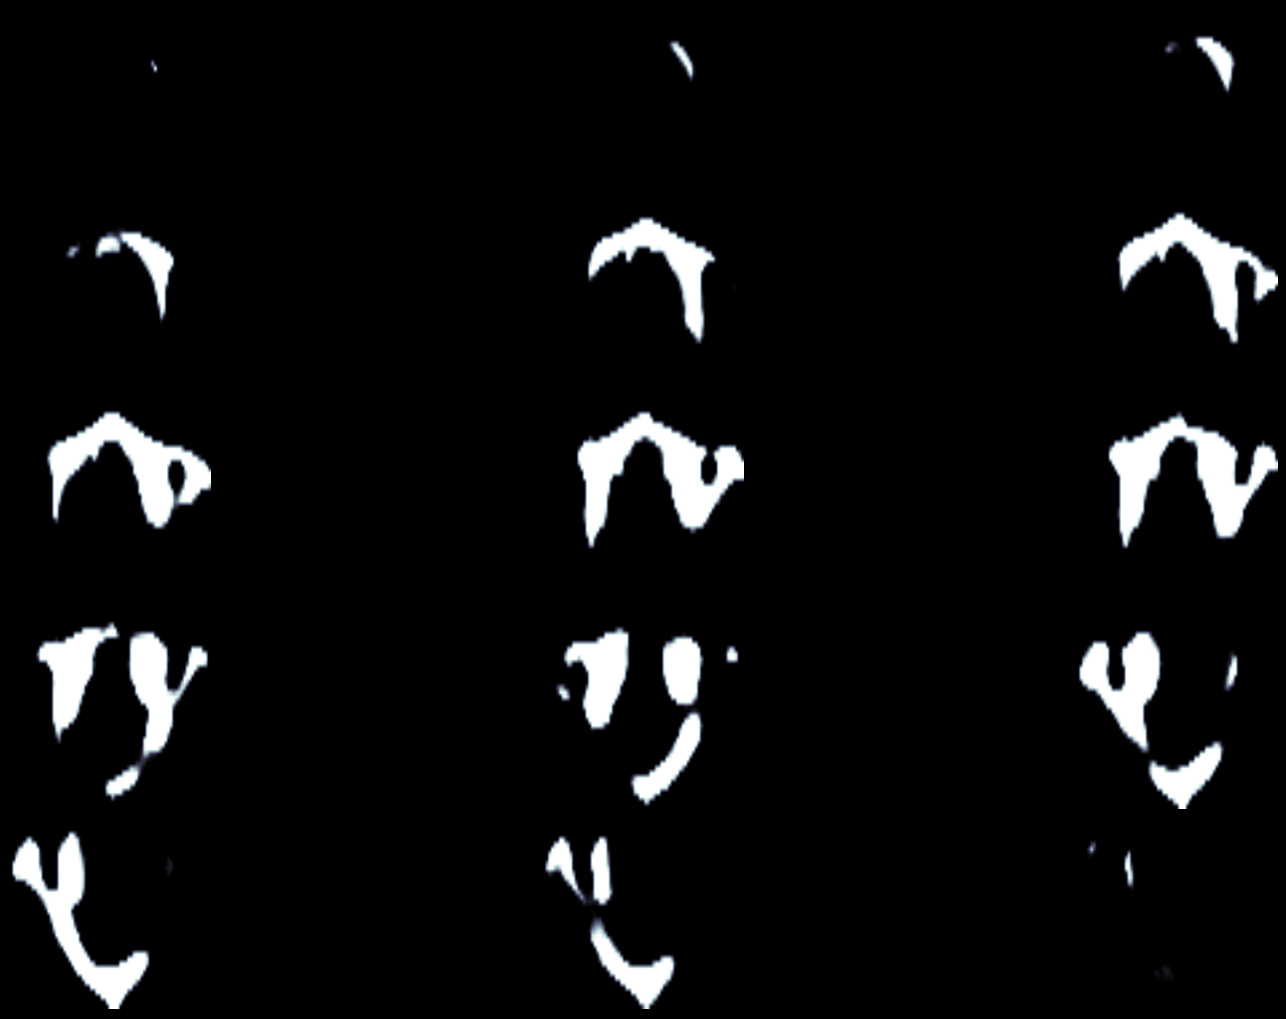

In [282]:
plot(data_list)

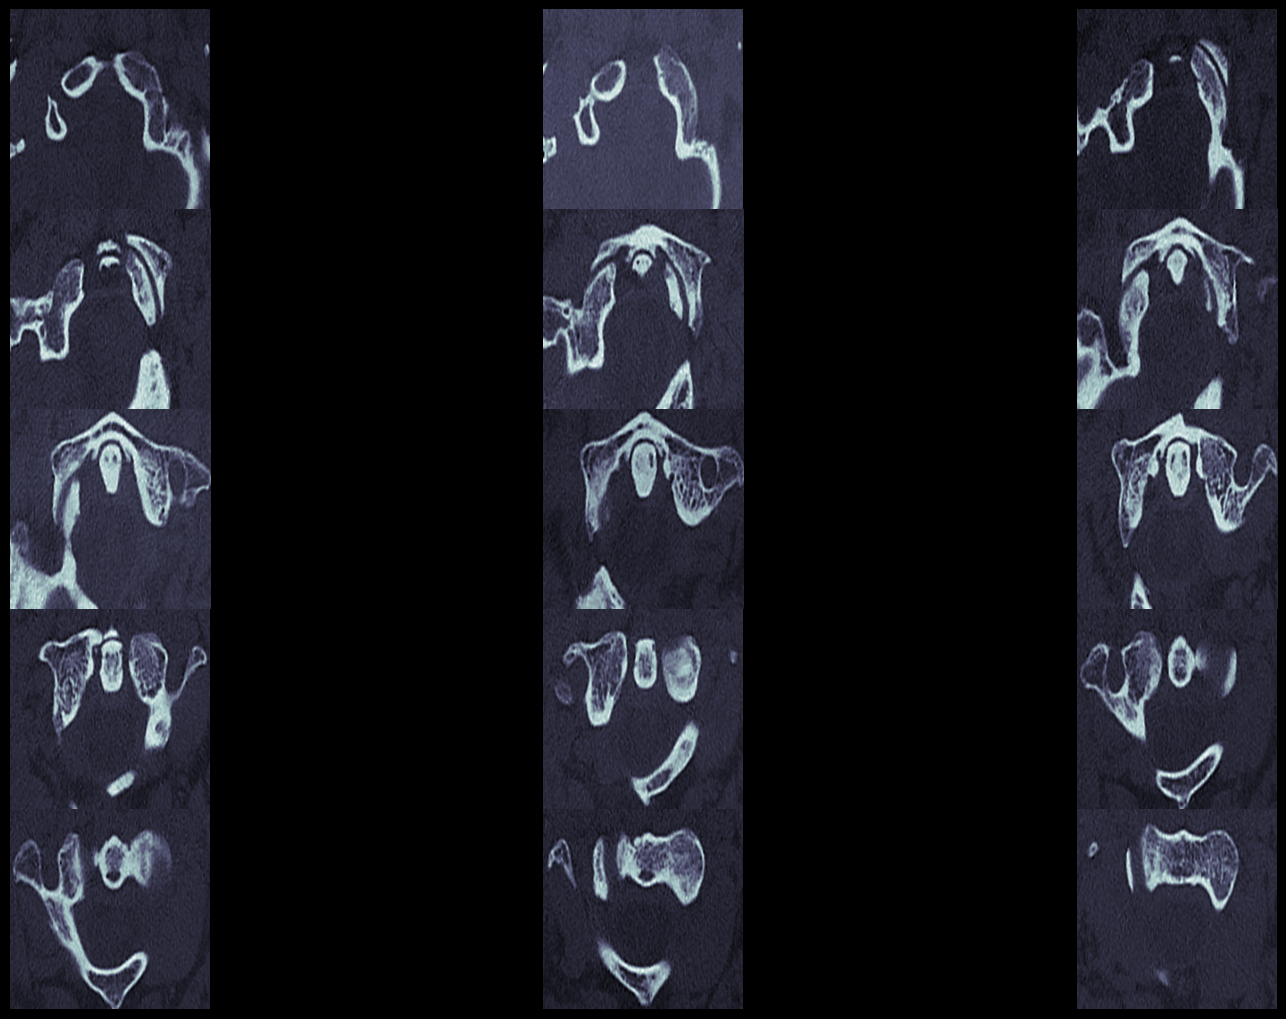

In [284]:
plot(image_list)

In [5]:
image_list_reshaped = []
for i in image_list:
  j = np.reshape(i, (1, 224, 224))
  image_list_reshaped.append(j)
image_list_reshaped = np.concatenate(image_list_reshaped, axis=0)
print(len(image_list_reshaped))
print(image_list_reshaped.shape)

15
(15, 224, 224)


In [6]:
data_list_reshaped = []
for i in data_list:
  j = np.reshape(i, (1, 224, 224))
  data_list_reshaped.append(j)
data_list_reshaped = np.concatenate(data_list_reshaped, axis=0)
print(len(data_list_reshaped))
print(data_list_reshaped.shape)

15
(15, 224, 224)


In [205]:
print(data_list_reshaped.shape[0])

15


In [291]:
import matplotlib.pyplot as plt

def plot_side_by_side(arr1, arr2):
    fig, axes = plt.subplots(nrows=8, ncols=4, figsize=(5, 16))

    for i in range(8):
        # Plot image from arr1
        axes[i, 0].imshow(arr1[i], cmap='gray')
        axes[i, 0].axis('off')
        axes[i, 0].set_title(f"Image Slice: {i}", fontsize=8, weight='bold')
        # Add space between the images
        axes[i, 0].annotate('', xytext=(0.5,0.5), xy=(0.5,1), xycoords='axes fraction',
                         arrowprops=dict(arrowstyle="-", color='w', lw=1), ha='center', va='center')

        # Plot image from arr2
        axes[i, 1].imshow(arr2[i], cmap='gray')
        axes[i, 1].axis('off')
        axes[i, 1].set_title(f"Mask Slice: {i}", fontsize=8, weight='bold')

    for i in range(8):
        # Plot image from arr1 in the third column
        axes[i, 2].imshow(arr1[7+i], cmap='gray')
        axes[i, 2].axis('off')
        axes[i, 2].set_title(f"Image Slice: {i+8}", fontsize=8, weight='bold')
        # Add space between the images
        axes[i, 3].annotate('', xytext=(0.5,0.5), xy=(0.5,1), xycoords='axes fraction',
                         arrowprops=dict(arrowstyle="-", color='w', lw=1), ha='center', va='center')

        # Plot image from arr2 in the fourth column
        axes[i, 3].imshow(arr2[7+i], cmap='gray')
        axes[i, 3].axis('off')
        axes[i, 3].set_title(f"Mask Slice: {i+8}", fontsize=8, weight='bold')
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=0.75)
    plt.show()

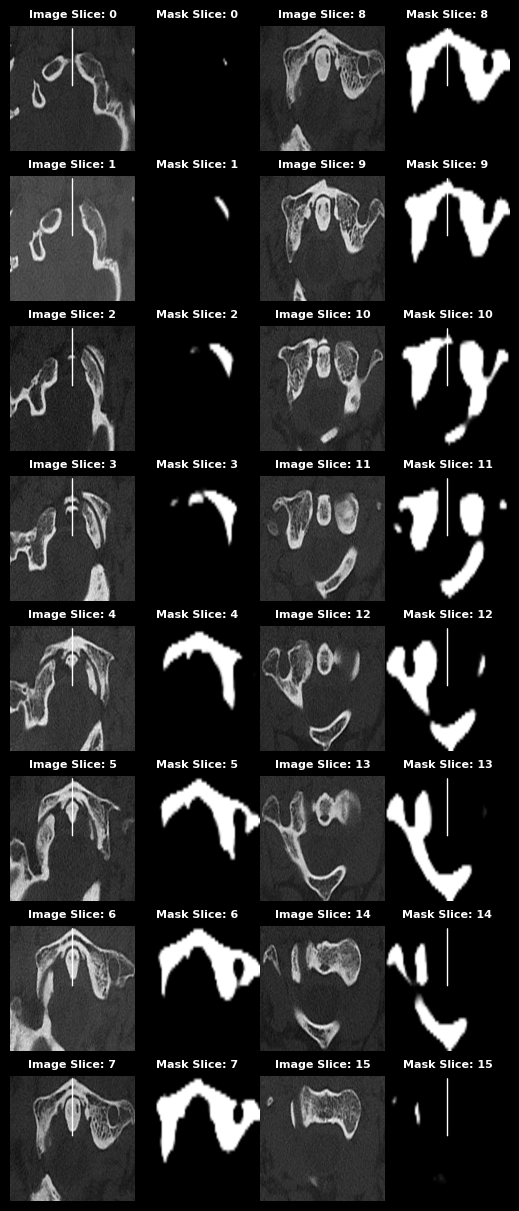

In [292]:
plot_side_by_side(image_list_reshaped,data_list_reshaped)

3D

In [9]:
plt.style.use('dark_background')

#dcm_paths is slices from read_plot_dicom_mask function

class DrawMaskSample():
    def __init__(self, slices, i, ax):
        self.i = i
        self.ax = ax
        #self.dcm_sample = pydicom.dcmread(dcm_paths[self.i])
        self.dcm_sample = slices
        print(f'sample({i+1}) shape: {self.dcm_sample.shape}')
        self.get_xyz()
        self.draw_sample_3d()

    def get_xyz(self):
        self.xyz_li = []
        cnt = 0
        max_cnt = self.dcm_sample.shape[-1]
        for iter_z, (iter_img) in enumerate(self.dcm_sample.transpose(2,0,1)):
            for iter_x, iter_arr_y in enumerate(iter_img):
                iter_arr_y = np.where(iter_arr_y)[0]
                if len(iter_arr_y) >= 1:
                    iter_arr_y = list(set([iter_arr_y.max(), iter_arr_y.min()]))
                    xyz = [(iter_x, iter_y, iter_z) for iter_y in iter_arr_y if np.any(iter_y)]
                    self.xyz_li.append(xyz)
            cnt += 1
            if (cnt % 100 == 0) | (cnt == max_cnt):
                print(f'iteration: ({cnt} / {max_cnt})')

    def draw_sample_3d(self):
        xyz_matrix = np.array(list(chain.from_iterable(self.xyz_li)))
        X = xyz_matrix[:,0]
        Y = xyz_matrix[:,1]
        Z = xyz_matrix[:,2]

        self.ax.scatter(X, Y, Z, s=10, alpha=0.5, color='white')
        xlim, ylim, zlim = self.dcm_sample.shape
        self.ax.set_xlim(0, xlim)
        self.ax.set_ylim(0, ylim)
        self.ax.set_zlim(0, zlim)
        self.ax.set_title(f'sample - ({self.i+1})',fontdict={'fontsize': 12})
        self.ax.tick_params(axis='x', labelsize=8)
        self.ax.tick_params(axis='y', labelsize=8)
        self.ax.tick_params(axis='z', labelsize=8)

sample(1) shape: (15, 224, 224)
iteration: (100 / 224)
iteration: (200 / 224)
iteration: (224 / 224)
sample(2) shape: (15, 224, 224)
iteration: (100 / 224)
iteration: (200 / 224)
iteration: (224 / 224)


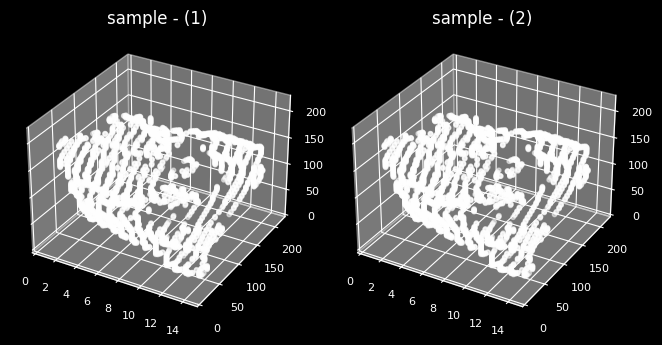

In [294]:
fig = plt.figure(figsize=(10,10))
for i in range(2):
    ax = fig.add_subplot(int(f'33{i+1}'), projection='3d')
    DrawMaskSample(data_list_reshaped, i, ax)

plt.tight_layout()
plt.show()

In [11]:
### 3D interactive ploting helper
def plotly_3d(verts, faces, ext=True):
    x, y, z = zip(*verts)
    fig = create_trisurf(
        x=x,
        y=y,
        z=z,
        plot_edges=False,
        show_colorbar=False,
        showbackground=False,
        colormap=["rgb(236, 236, 212)", "rgb(236, 236, 212)"] if ext else ["rgb(255, 107, 107)", "rgb(255, 107, 107)"],
        simplices=faces,
        backgroundcolor="rgb(30, 39, 46)",
        gridcolor="rgb(30, 39, 46)",
        title="<b>Interactive Visualization</b>",
    )
    fig.layout.template = "plotly_dark"  # for dark theme
    fig.show()

def plot3d_interactive_ext(masks, reverse=False):
    v, f = generate_surface(masks, lower_bound=0, upper_bound=0, threshold=0)
    plotly_3d(v, f)

def generate_surface(image, lower_bound = 700, upper_bound =3000, threshold=0.5, step_size=1):
    # Threshold the image
    thresholded_image = np.zeros_like(image)
    thresholded_image[(image >= lower_bound) & (image <= upper_bound)] = 1

    # Generate a surface using the marching cubes algorithm
    p = thresholded_image.transpose(2, 1, 0)
    verts, faces, _, _ = measure.marching_cubes(p, threshold, step_size=step_size, allow_degenerate=True)

    return verts, faces

In [296]:
plot3d_interactive_ext(data_list_reshaped)

# Numpy2STL

In [7]:
!pip install numpy-stl

In [12]:
from stl import mesh

def save_stl(verts, faces, output_file):
    # Create the STL mesh object
    stl_mesh = mesh.Mesh(np.zeros(len(faces), dtype=mesh.Mesh.dtype))
    for i, face in enumerate(faces):
        for j in range(3):
            stl_mesh.vectors[i][j] = verts[face[j]]

    # Save the STL file
    stl_mesh.save(output_file)
    print(f"Saved STL file as '{output_file}'")

verts, faces = generate_surface(data_list_reshaped, lower_bound=0, upper_bound=0, threshold=0)  # Assuming you have the 'image' data
output_file = 'output.stl'
save_stl(verts, faces, output_file)

Saved STL file as 'output.stl'


In [13]:
from google.colab import files
# Download the STL file
files.download(output_file)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Using Mimics masks for CT50_dataset

In [18]:
def read_dicom_file(filepath):
    files = []
    for fname in glob(filepath):
        files.append(pydicom.dcmread(fname))
    print(f"file count: {len(files)}")
    return files

def read_mask(mask):
  slices = []
  skipcount = 0
  for f in mask:
      if hasattr(f, 'InstanceNumber'):
          slices.append(f)
      else:
          skipcount = skipcount + 1

  slices = sorted(slices, key=lambda s: s.InstanceNumber)
  slices = np.stack([s.pixel_array for s in slices])

  return slices

In [21]:
mask = read_dicom_file("/content/gdrive/MyDrive/KOLN3D/DL_BoneImageSeg/CT26_mask/*")
masks = read_mask(mask)
mverts, mfaces = generate_surface(masks, lower_bound=0, upper_bound=0, threshold=0)  # Assuming you have the 'image' data
mask_file = 'mask_CT26.stl'
save_stl(mverts, mfaces, mask_file)
files.download(mask_file)

file count: 569
Saved STL file as 'mask_CT26.stl'


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>